# Feature Extraction in the Frequency Domain

In [ ]:
# Goal: Practice generating some frequency domain features and working with spectrograms

# Tasks:
# - Practice creating spectrograms using best frame length for human speech, as well as 
#   ultrasonic and infrasonic animal vocalizations. 
# - Filter out lower frequencies to remove background noise and isolate ultrasonic sound
# - Extract MFCCs and examine change in MFCC values over time
# - Extract and visualize spectral centroid and bandwidth

# Audio used:
# - Human conversation
# - Bat echolocation calls (ultrasound)
# - Elephant rumbles (most energy is infrasonic)

# Date last updated: 1/21/2025
# Author: Kay Rubio

In [1]:
# Check python version for compatibility with librosa
!python3 --version

Python 3.12.8


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

## Load and explore audio

In [7]:
audio_folder = "Sounds/sample_audios/"

convo, sr_convo = librosa.load(audio_folder+"convo.wav") # example human convo, use librosa default sample rate
bat, sr_bat = librosa.load(audio_folder+"bat.wav", sr=None) # retain original sample rate for ultrasound
elephant, sr_elephant = librosa.load(audio_folder+"elephants.wav", sr=8000) # use lower sample rate

In [8]:
# Check SR's
print(f"Speech sample rate: {sr_convo}")
print(f"Bat sample rate: {sr_bat}")
print(f"Elephant sample rate: {sr_elephant}")

Speech sample rate: 22050
Bat sample rate: 384000
Elephant sample rate: 8000


In [124]:
# Listen to an audio file in notebook using IPython.display
# ipd.Audio(audio_folder+"convo.wav")

In [125]:
# If you are human, you won't hear anything but wind because it's ultrasound
# ipd.Audio(audio_folder+"bat.wav")

In [126]:
# You will partially hear these rumbles which are partially audible, partially infrasound
# ipd.Audio(audio_folder+"elephants.wav")

In [14]:
# Check the sample durations, bat sample should be way smaller as sampling rate is much higher
sample_duration = 1 / sr_convo*1000
print(f"One sample of human conversation audio lasts for {sample_duration:.7f} milliseconds")
sample_duration = 1 / sr_bat*1000
print(f"One sample of bat audio lasts for {sample_duration:.7f} milliseconds")
sample_duration = 1 / sr_elephant*1000
print(f"One sample of elephant audio lasts for {sample_duration:.7f} milliseconds")

One sample of human conversation audio lasts for 0.0453515 milliseconds
One sample of bat audio lasts for 0.0026042 milliseconds
One sample of elephant audio lasts for 0.1250000 milliseconds


## Helper methods

In [17]:
# Function to plot 1 waveform
def plotWaveform(audio, title):
    plt.figure(figsize=(15, 3))
    librosa.display.waveshow(audio, sr=sr, alpha=0.5)
    plt.title(title)
    plt.xlabel("Time (sec)") 
    plt.ylabel("Amplitude")
    plt.show()

In [20]:
# Function to plot multiple waveforms in 1 figure
# audios and titles should be arrays of equal length
# also assumes sr is already defined as variable sr
def plotWaveforms(audios, titles, sample_rates):
    if(len(audios) != len(titles) or len(audios) != len(sample_rates)):
        raise ValueError(f"Error: audios, titles, and sample_rates should be arrays of the same length")
    num_of_waves = len(audios)
    plt.figure(figsize=(15, 8))
    for i, audio in enumerate(audios):
        plt.subplot(num_of_waves, 1, i+1) # create subplots of 3 files
        librosa.display.waveshow(audio, sr=sample_rates[i], alpha=0.5)
        plt.title(titles[i])
    plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing for titles
    plt.show()

In [49]:
# Function to extract Short-Time Fourier Transform
def st_fourier_transform(audio, n_fft, hop_length, type="power"):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length) # outputs matrix of complex numbers for stft
    # stft.shape # optional - check shape
    # type(stft[0][0]) # optional - check output type, should be complex number containing phase & amplitude
    
    # Remove complex numbers to retain just amplitude/power, and transform to decibels to improve visualization
    if type=="power":
        stft_abs = np.abs(stft) ** 2 # use for a power spectrogram
        stft_dB = librosa.power_to_db(np.abs(stft_abs), ref=np.max)
    elif type=="amplitude":
        stft_abs = np.abs(stft) # use for an amplitude spectrogram
        stft_dB = librosa.amplitude_to_db(np.abs(stft_abs), ref=np.max)
    else:
        raise ValueError(f"Error: type should be 'power' or 'amplitude'")
    # type(stft_abs[0][0]) # optional - check to ensure no longer complex
    return stft_dB

In [42]:
# Function to plot spectrograms with zoom in on the x-axis
def plot_spectrogram(Y, sr, hop_length, y_axis="mel", fmin=0, fmax=20000):
    plt.figure(figsize=(25, 10)) # instantiate a figure and give a size
    # use librosa.display.specshow to visualize any type of spectrogram
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis
		)
    plt.ylim(fmin, fmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')    
    plt.colorbar(format="%+2.f") # add a color bar legend
    plt.title('Spectrogram')
    plt.show()

In [43]:
# Function to plot spectrograms with zoom in on the x-axis
def plot_spectrogram_zoomx(stft, sr, hop_length, y_axis="mel", fmin=0, fmax=20000, xmin=0, xmax=12):
    plt.figure(figsize=(25, 10)) # instantiate a figure and give a size
    # use librosa.display.specshow to visualize any type of spectrogram
    librosa.display.specshow(stft, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis
		)
    plt.ylim(fmin, fmax)
    plt.xlim(xmin, xmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')    
    plt.colorbar(format="%+2.f") # add a color bar legend
    plt.title('Spectrogram')
    plt.show()

In [ ]:
# Function to plot spectral centroid and bandwidth
def plot_spectral_centroid(sc, sban, time, title):
    # Calculate upper and lower bounds
    upper = np.array(sc) + np.array(sban)
    lower = np.array(sc) - np.array(sban)
    plt.figure(figsize=(25,10))
    plt.plot(t, sc, color='b', label='Spectral Centroid')
    plt.fill_between(time, upper, lower, alpha=0.2, label='Spectral Bandwidth')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Spectral centroid values')
    plt.title(title)
    plt.legend()
    plt.show()

## Plot waveforms for reference

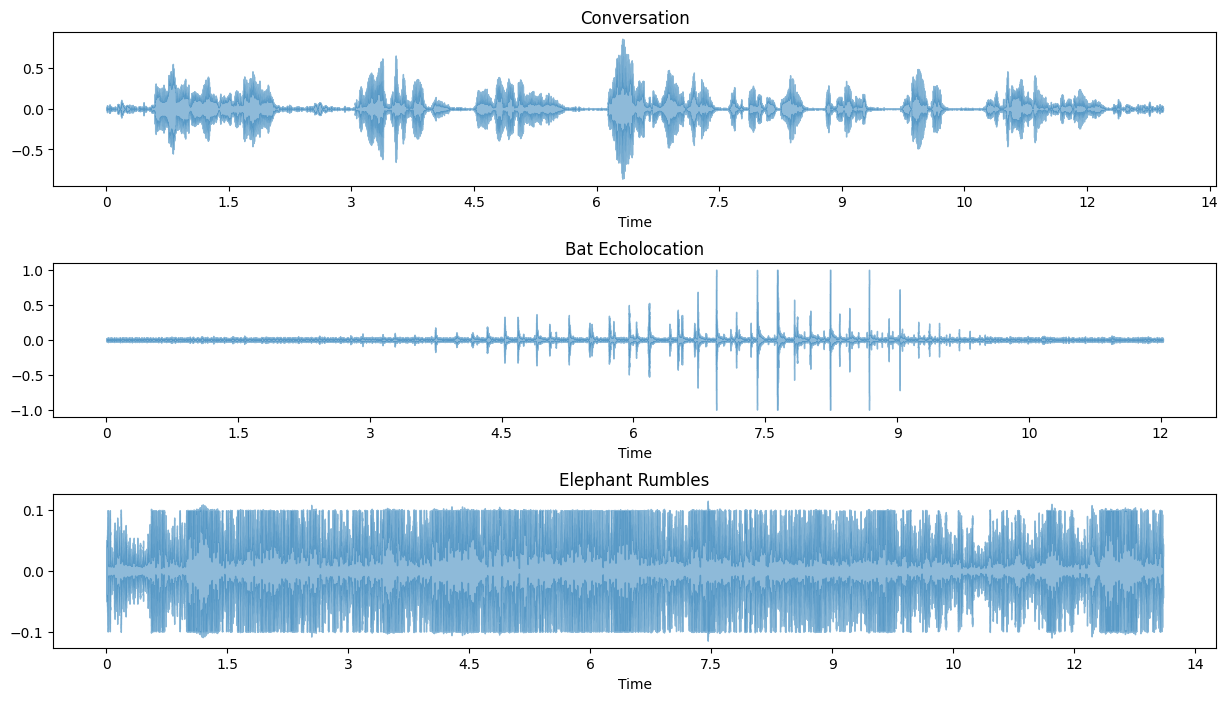

In [21]:
audios = [convo, bat, elephant]
titles = ["Conversation", "Bat Echolocation", "Elephant Rumbles"]
sample_rates = [sr_convo, sr_bat, sr_elephant]
plotWaveforms(audios, titles, sample_rates)

In [24]:
# You can see from the waveforms that the bat and elephant vocalizations are quite loud, 
# around twice as loud as the human conversation, although listening to the files, most/all
# of the sound is not audible

## Spectrograms

### Spectrogram of human speech

In [26]:
# Plot spectrogram for human conversation
# librosa recommends FRAME_LENGTH=512 to prioritize time resolution, although 1024 and 2048 are OK too
FRAME_LENGTH = 512
HOP_LENGTH = FRAME_LENGTH//4

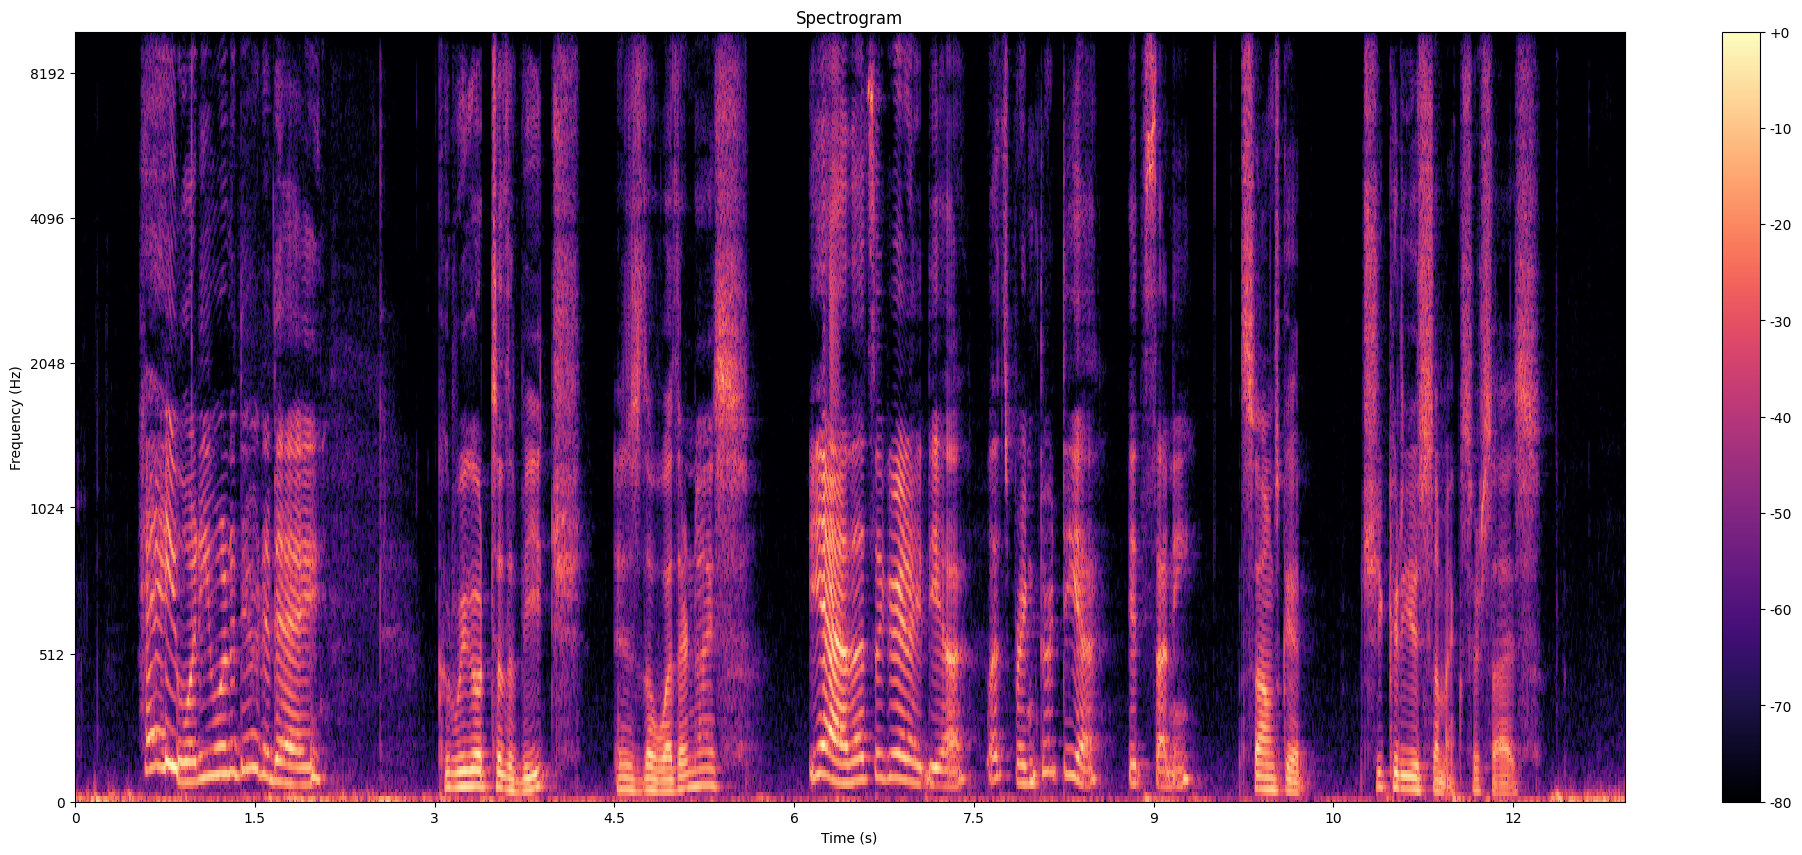

In [44]:
stft_convo = st_fourier_transform(convo, FRAME_LENGTH, HOP_LENGTH)
# Plot spectrogram, use the mel scale for frequency since this is human speech
plot_spectrogram(stft_convo, sr_convo, HOP_LENGTH, "mel", 0, 10000)

### Spectrogram of bat echolocation

In [58]:
# Plot spectrogram for bat ultrasound
# Note: tried FRAME_LENGTH_US = 4096 but the time resolution was too low, and tried 1024 
# but frequency resolution was poor so 2048 seems to be the best balance
FRAME_LENGTH_US = 2048
HOP_LENGTH_US = FRAME_LENGTH_US//4

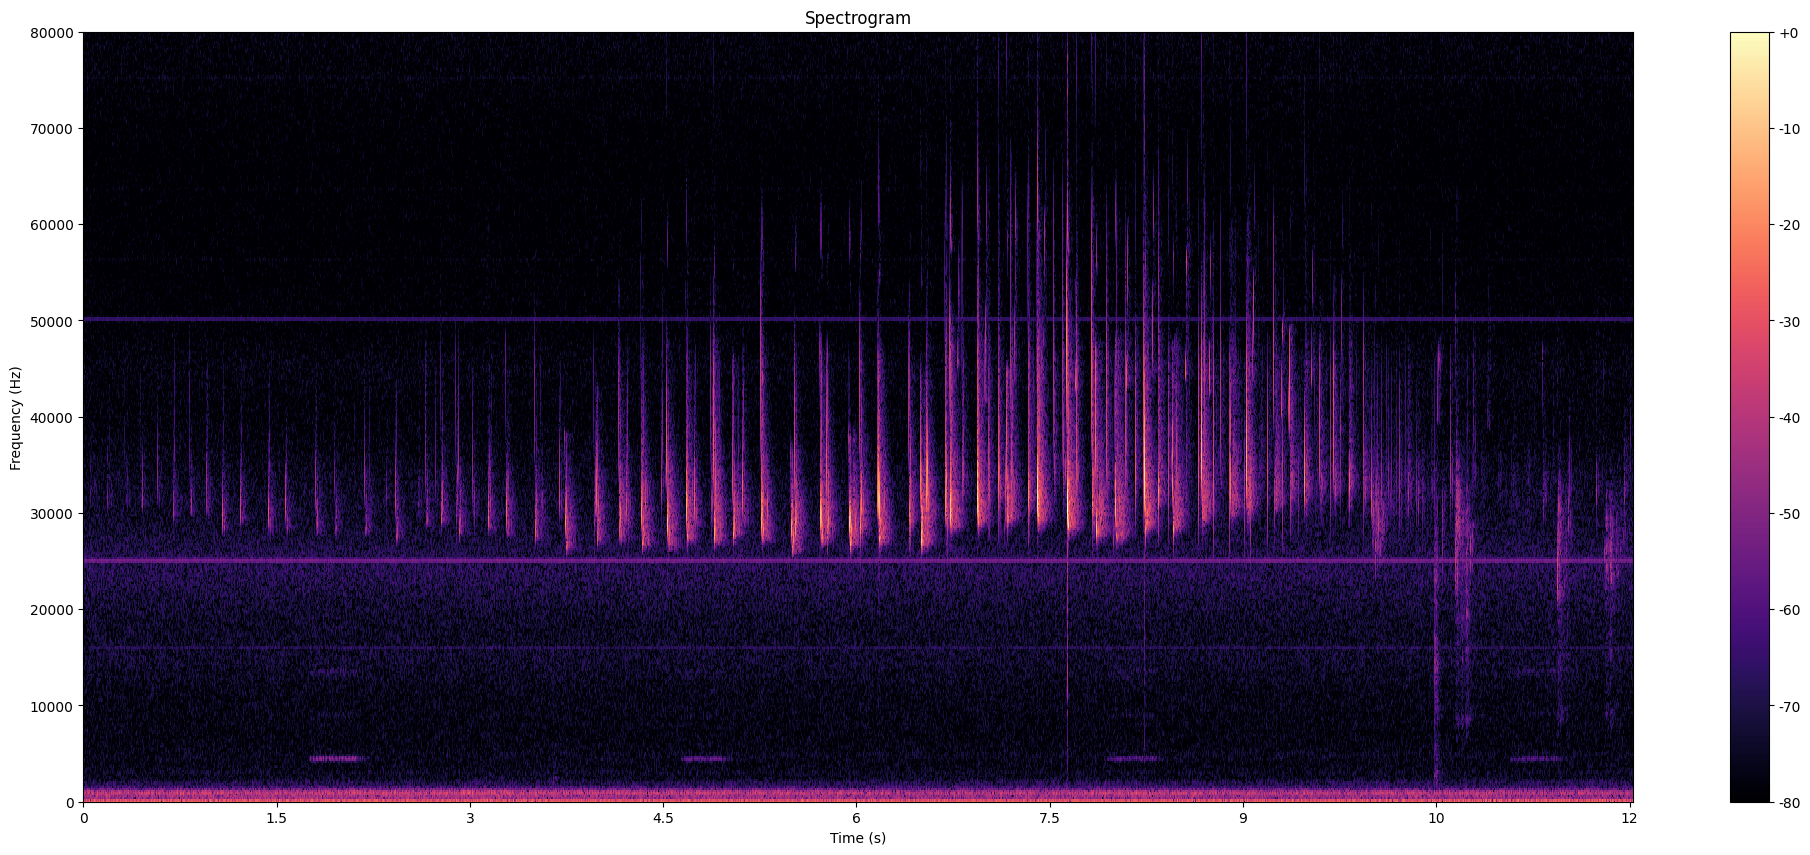

In [59]:
stft_bat = st_fourier_transform(bat, FRAME_LENGTH_US, HOP_LENGTH_US)
# Plot spectrogram, try linear scale for frequency since this is not human speech
plot_spectrogram(stft_bat, sr_bat, HOP_LENGTH_US, "linear", 0, 80000)

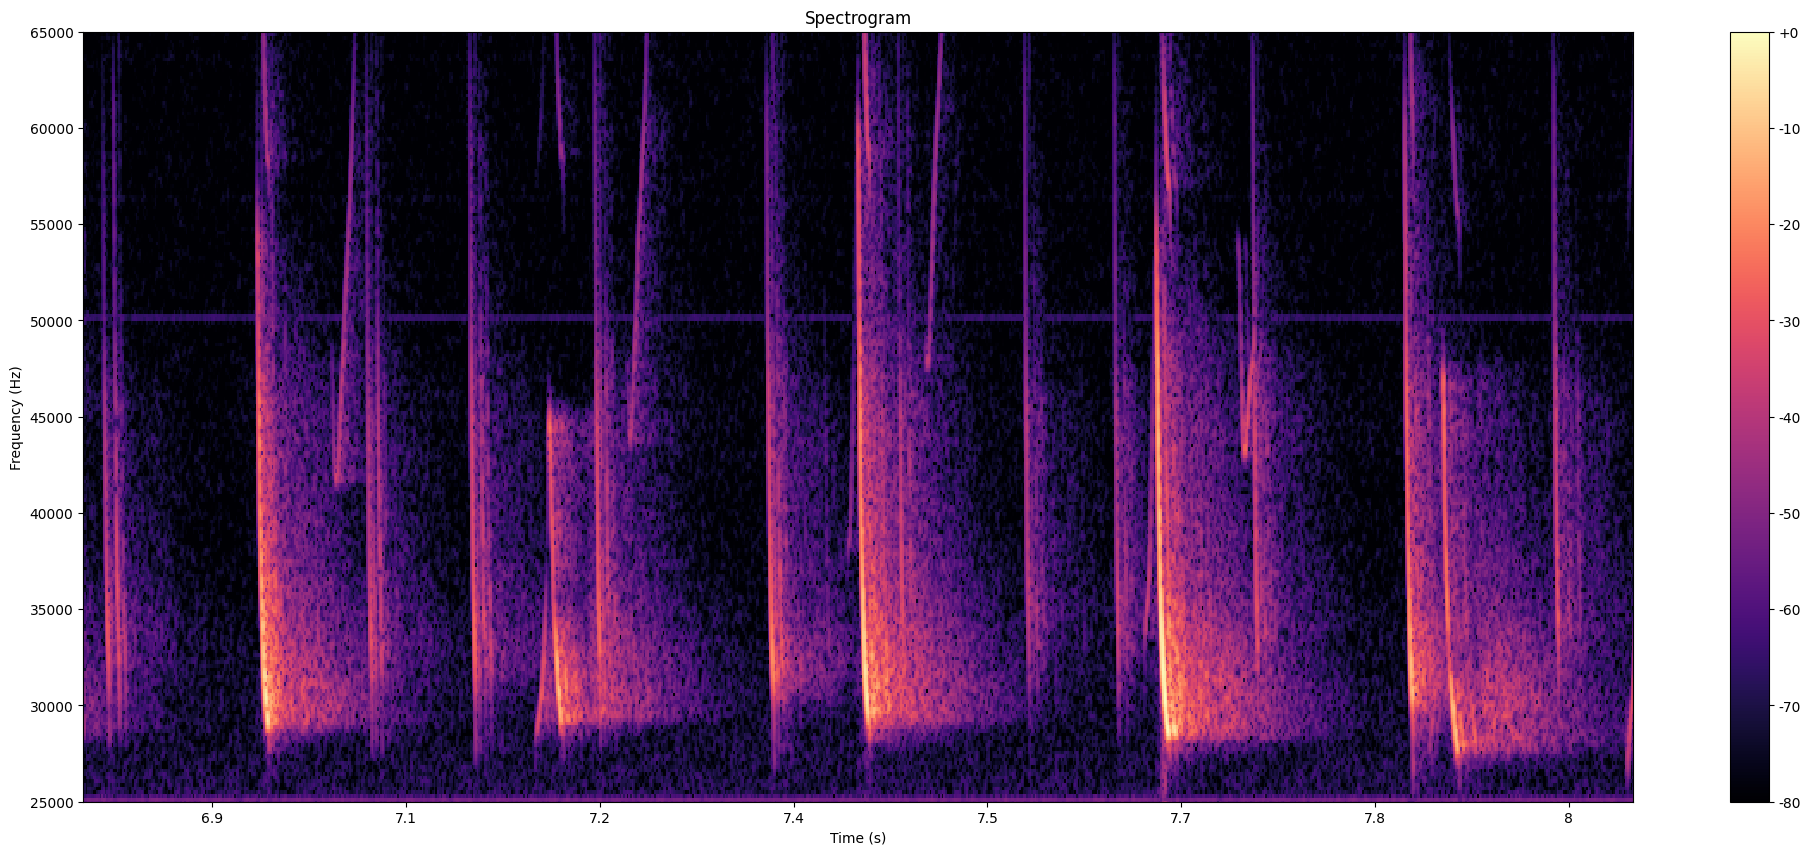

In [60]:
# Zoom in on highest frequencies and zoom in on time a bit to see more detail
plot_spectrogram_zoomx(stft_bat, sr_bat, HOP_LENGTH_US, "linear", 25000, 65000, 6.8, 8)

### Bat sound: Zero out all the frequency values below 25,000 Hz to isolate the sounds

In [62]:
# All bat energy is between 25,000 - 80,000 Hz, but there is also background noise and insect chirps at much 
# lower frequencies, so apply this cuttoff
CUTOFF_US = 25000

In [70]:
stft2_bat = librosa.stft(bat, n_fft=FRAME_LENGTH_US, hop_length=HOP_LENGTH_US)

In [71]:
# Get the frequency values corresponding to the rows of the STFT
bat_frequencies = librosa.fft_frequencies(sr=sr_bat, n_fft=FRAME_LENGTH_US)
bat_frequencies

array([0.000000e+00, 1.875000e+02, 3.750000e+02, ..., 1.916250e+05,
       1.918125e+05, 1.920000e+05])

In [72]:
# Find the index of the frequency closest to 25,000 Hz
cutoff_idx = np.argmax(bat_frequencies >= CUTOFF_US)
cutoff_idx

np.int64(134)

In [73]:
# Create a copy of the STFT matrix
stft_bat_filtered = stft2_bat.copy()

In [74]:
# Zero out frequencies below cutoff
stft_bat_filtered[:cutoff_idx, :] = 0

In [76]:
# Remove complex numbers, retain just amplitude, and raise to power of 2
stft_bat_filtered_abs = np.abs(stft_bat_filtered) ** 2 # use for a power spectrogram

In [77]:
# Transform amplitude OR power from linear to log scale decibels to improve visualization
stft_bat_filtered_dB = librosa.power_to_db(np.abs(stft_bat_filtered_abs), ref=np.max)

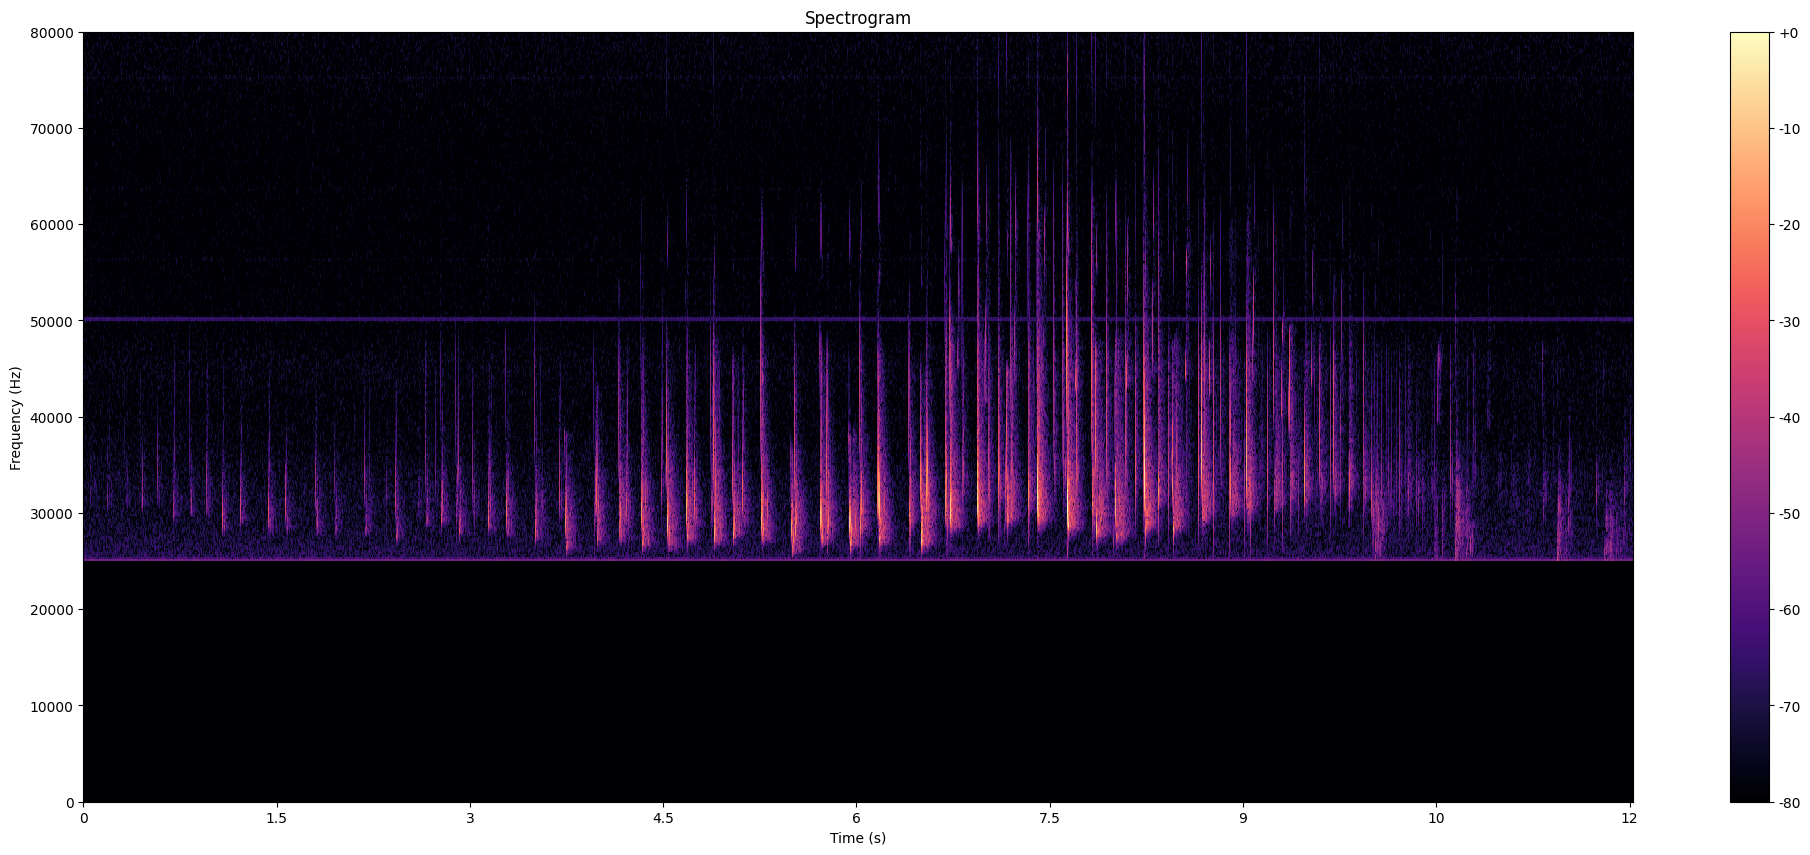

In [78]:
# Plot spectrogram for bats with lower frequency sounds filtered out
plot_spectrogram(stft_bat_filtered_dB, sr_bat, HOP_LENGTH_US, "linear", 0, 80000)

In [ ]:
# From the spectrogram, you can see that the lower frequencies have disappeared, isolating the bat sounds

In [79]:
# Convert back to the time domain using the inverse STFT
bat_filtered = librosa.istft(stft_bat_filtered, hop_length=HOP_LENGTH_US)

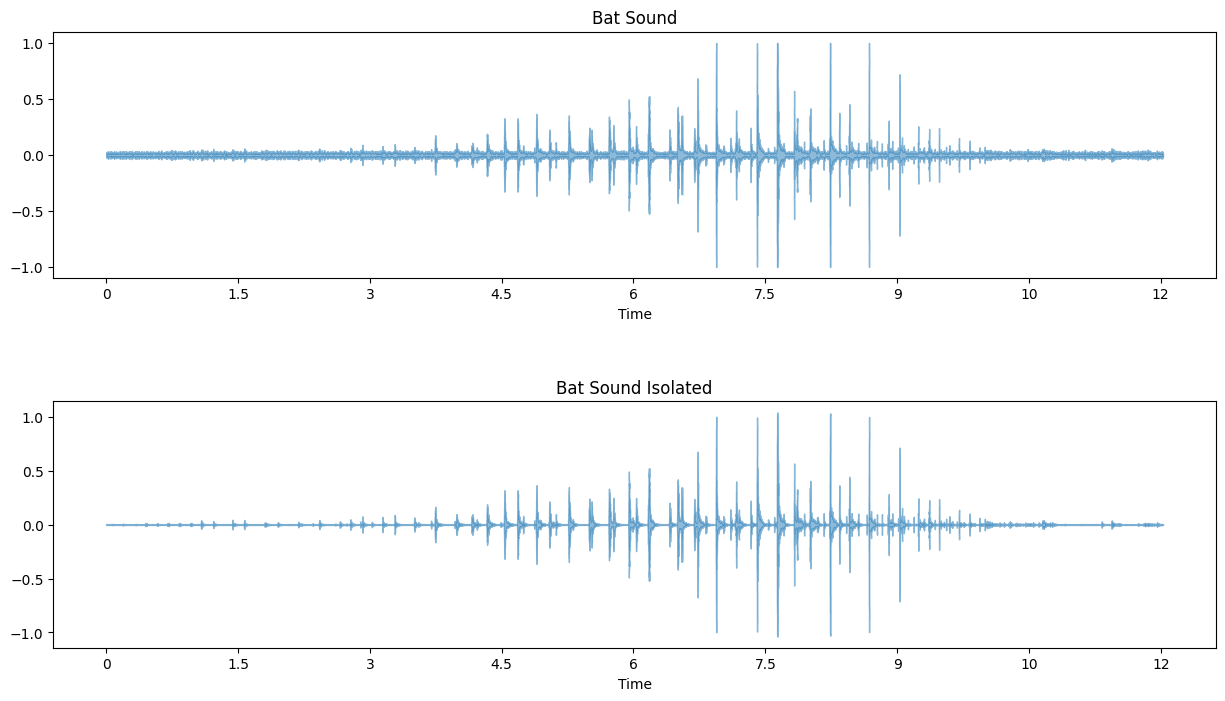

In [80]:
# Compare filtered bat spectrogram with original bat spectrogram
bats = [bat, bat_filtered]
titles = ["Bat Sound", "Bat Sound Isolated"]
sample_rates = [sr_bat, sr_bat]
plotWaveforms(bats, titles, sample_rates)

In [ ]:
# From above, you can see that removing the lower frequencies really isolated the bat sounds

### Spectrogram of elephant rumbles

In [81]:
# Plot spectrogram for elephant ultrasound
# Note: tried FRAME_LENGTH_US = 4096 but the time resolution was too low, and tried 1024 
# but frequency resolution was poor so 2048 seems to be the best balance
FRAME_LENGTH_IS = 2048
HOP_LENGTH_IS = FRAME_LENGTH_IS//4

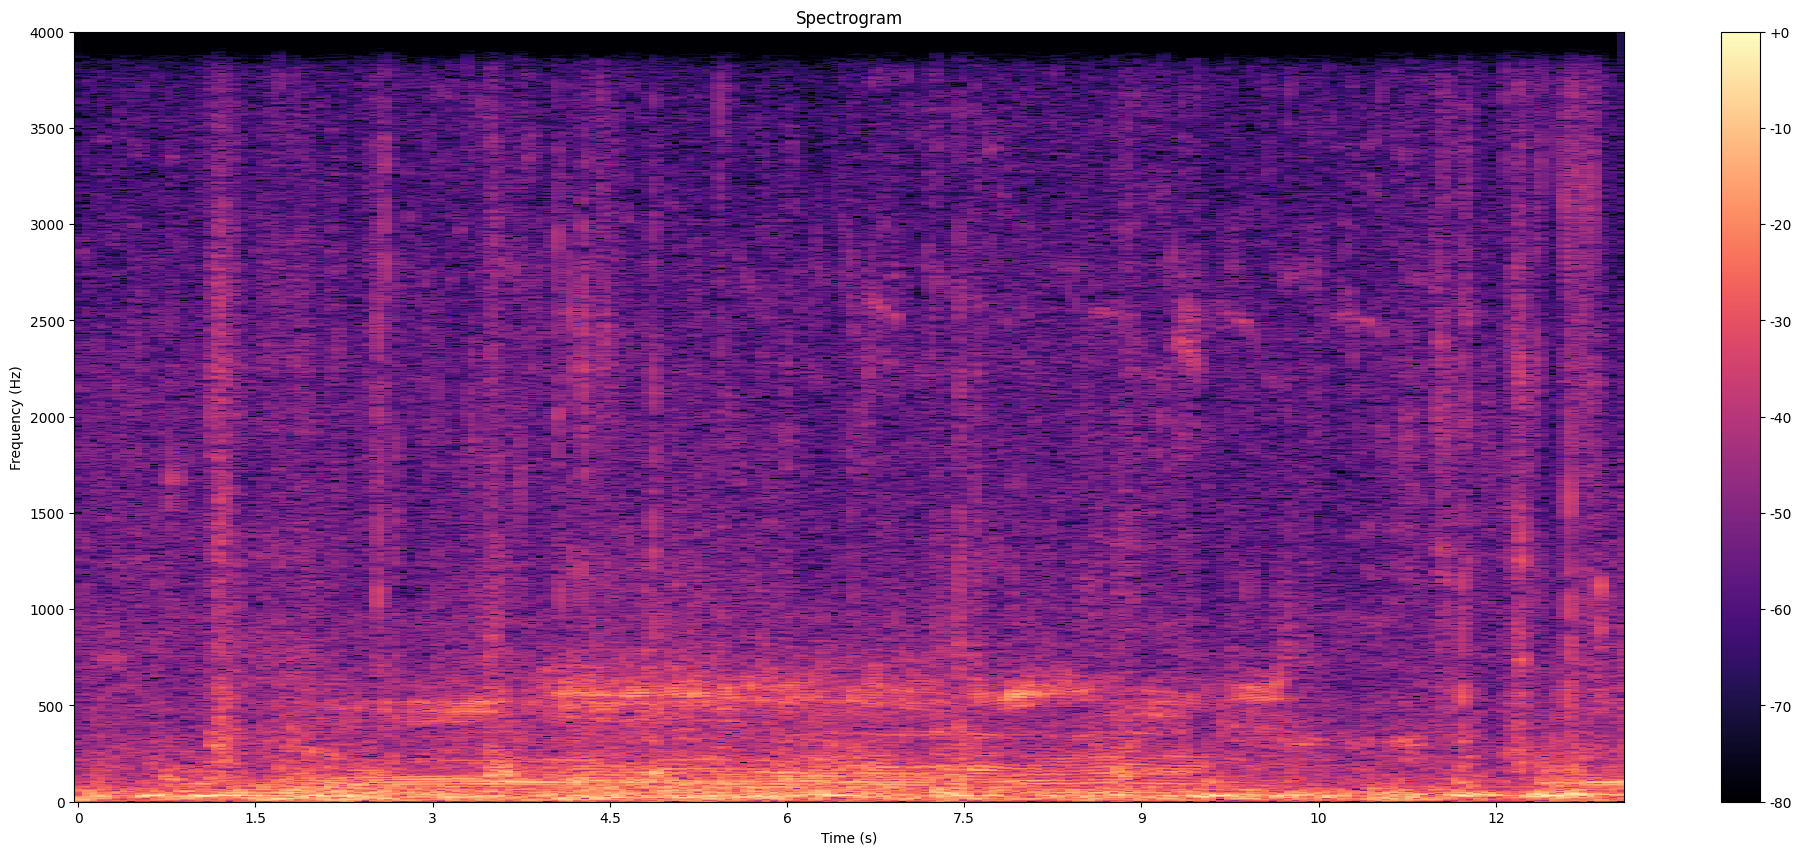

In [82]:
stft_elephant = st_fourier_transform(elephant, FRAME_LENGTH_IS, HOP_LENGTH_IS)
# Plot spectrogram, try linear scale for frequency since this is not human speech
# Also, limit y-axis to 4000Hz since sampling rate is 8000 so 4000 is the Nyquist frequency
plot_spectrogram(stft_elephant, sr_elephant, HOP_LENGTH_IS, "linear", 0, 4000)

## Extract MFCCs for human speech and examine change over time

In [84]:
mfccs_convo = librosa.feature.mfcc(y=convo, sr=sr_convo, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, n_mfcc=13)
mfccs_convo.shape

(13, 2228)

In [86]:
# The output of mfcc is a matrix with 13 rows for the first 13 MFCCs, and 2228 columns for frames
# Look at the MFCCs at a frame in the middle
mfccs_convo[:, 1114]

array([-344.91626  ,  141.9231   ,  -43.413788 ,    8.722172 ,
         26.028633 ,   -1.0389882,    9.269884 ,  -26.065685 ,
        -18.481136 ,   13.1181965,  -24.080147 ,   10.6191   ,
        -25.258999 ], dtype=float32)

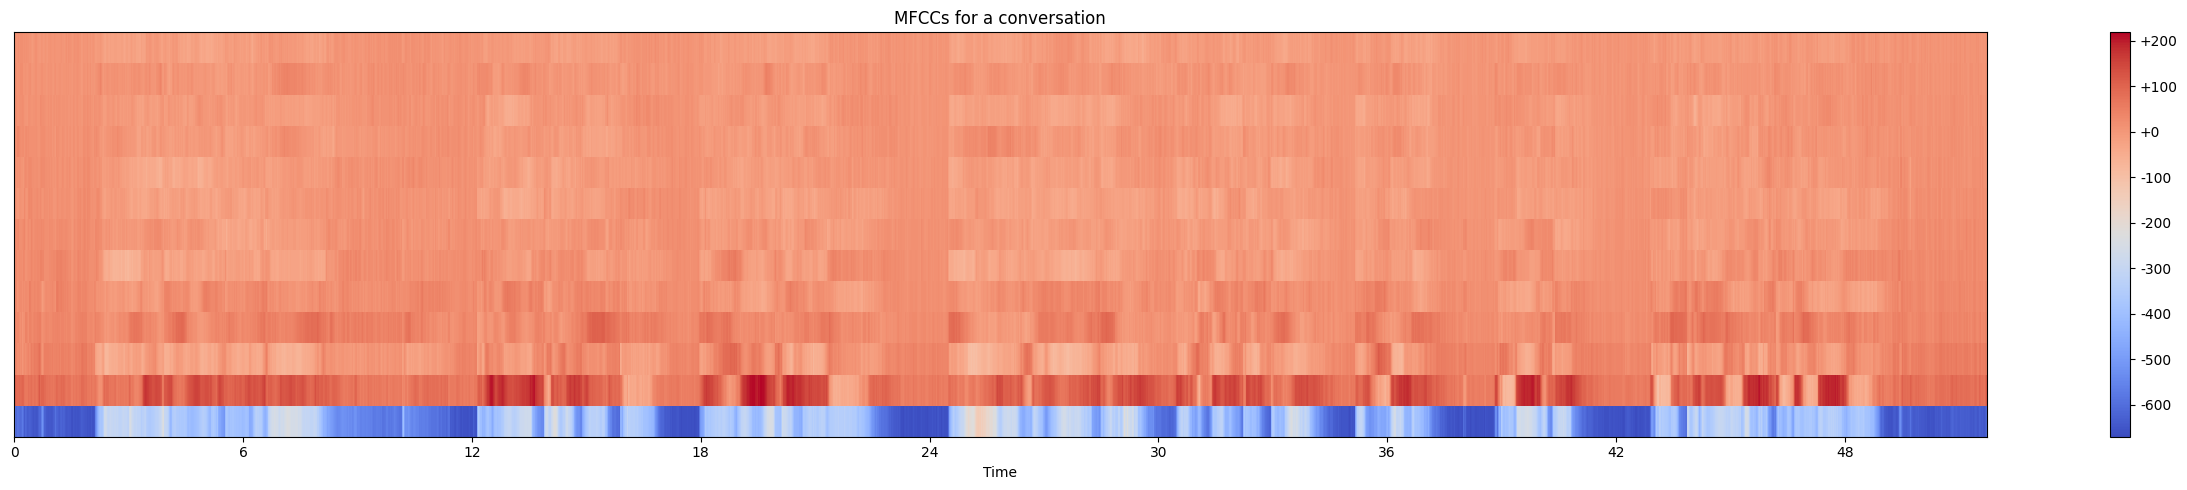

In [91]:
# Visualizing MFCCs
plt.figure(figsize=(25, 5))
librosa.display.specshow(mfccs_convo, x_axis='time', sr=sr_convo)
plt.colorbar(format="%+2.f") # format is optional argument
plt.title('MFCCs for a conversation')
plt.tight_layout()
plt.show()

In [88]:
# Computing first MFCCs derivatives (how they change from frame-frame over time)
delta_mfccs_convo = librosa.feature.delta(mfccs_convo)

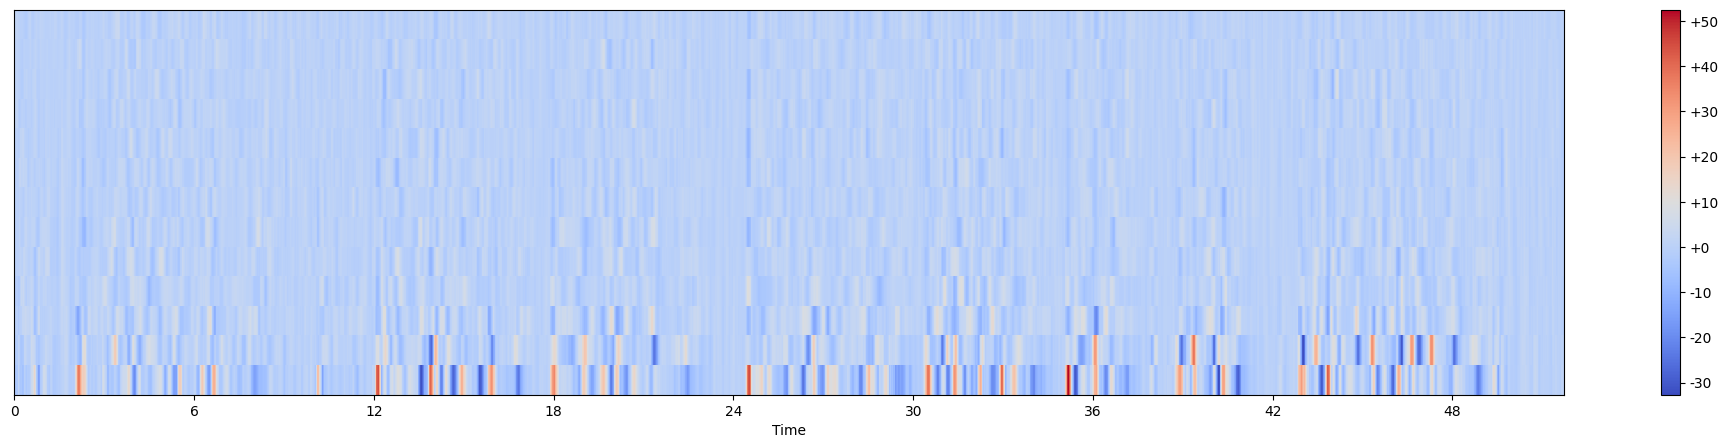

In [92]:
plt.figure(figsize=(25, 5))
librosa.display.specshow(delta_mfccs_convo, 
                         x_axis="time", 
                         sr=sr_convo)
plt.colorbar(format="%+2.f")
plt.show()

## Spectral centroid and bandwidth

In [94]:
# Calculate spectral centroid for conversation
sc_convo = librosa.feature.spectral_centroid(y=convo, sr=sr_convo, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

In [96]:
# Calculate spectral bandwidth for conversation
sban_convo = librosa.feature.spectral_bandwidth(y=convo, sr=sr_convo, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

In [97]:
frames = range(len(sc_convo))
t = librosa.frames_to_time(frames, sr=sr_convo, hop_length=HOP_LENGTH)

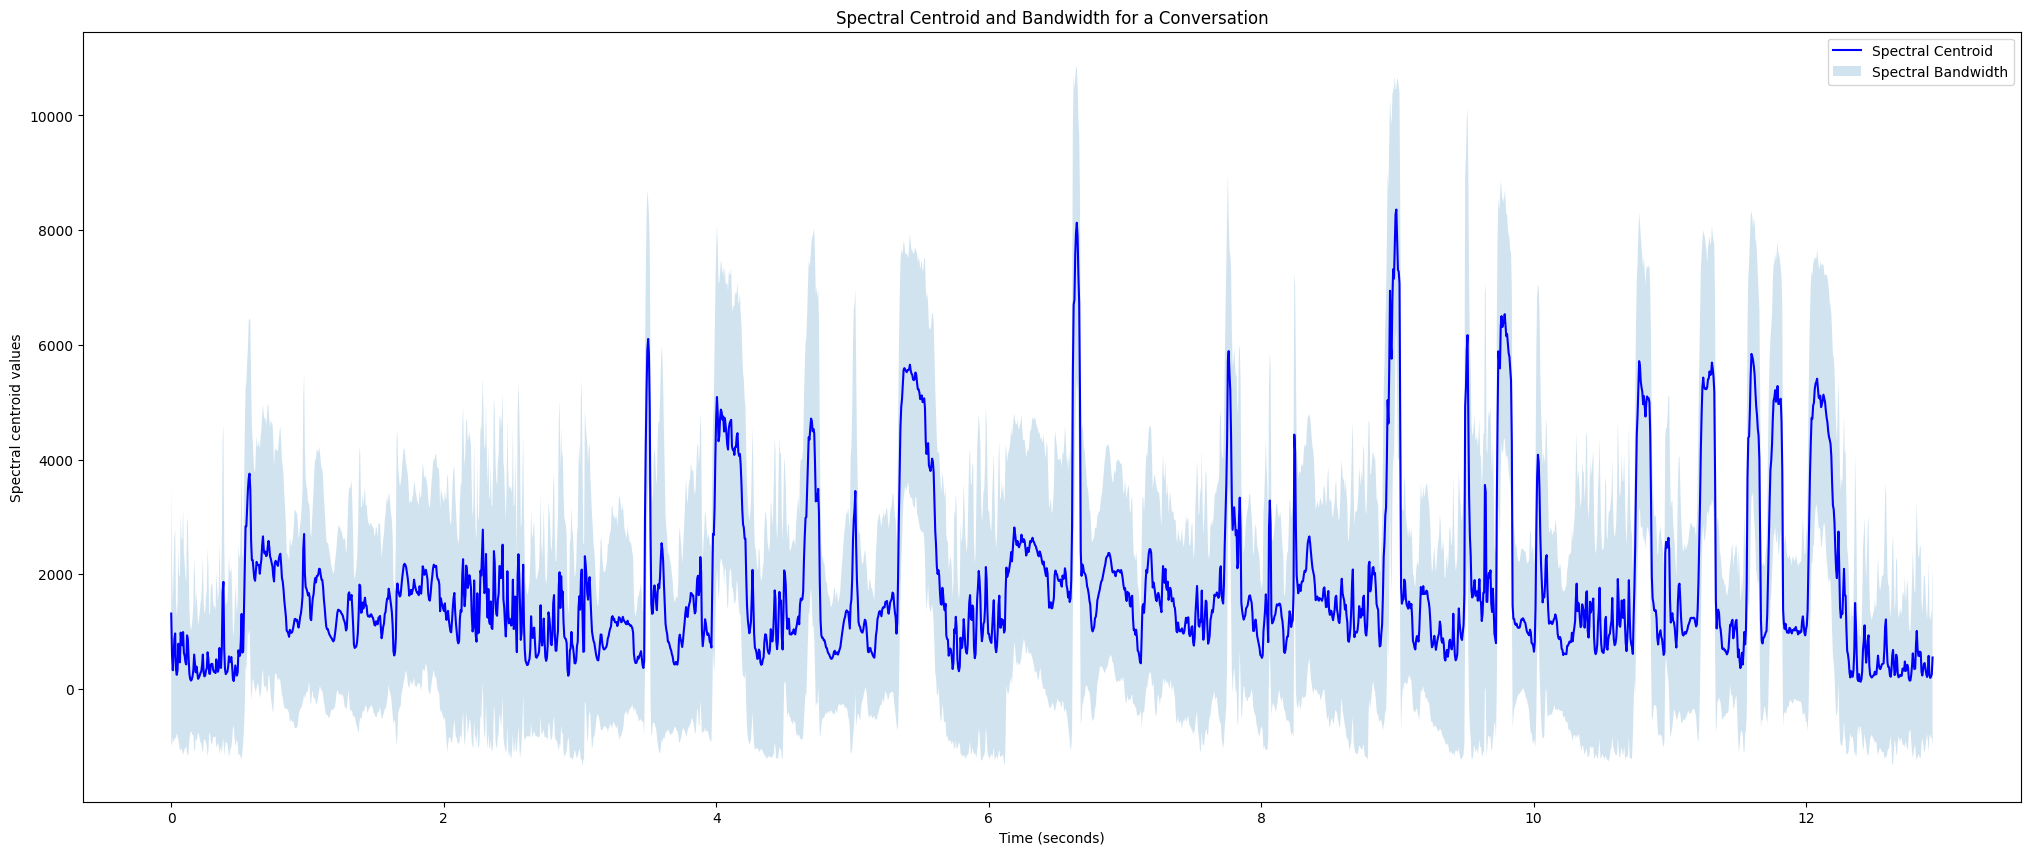

In [100]:
# Plot spectral centroid and bandwidth for conversation
plot_spectral_centroid(sc_convo, sban_convo, t, 'Spectral Centroid and Bandwidth for a Conversation')

In [105]:
# Calculate spectral centroid for bat sound (filtered to remove lower frequencies)
sc_bat = librosa.feature.spectral_centroid(y=bat_filtered, sr=sr_bat, n_fft=FRAME_LENGTH_US, hop_length=HOP_LENGTH_US)[0]

In [106]:
# Calculate spectral bandwidth for bat
sban_bat = librosa.feature.spectral_bandwidth(y=bat_filtered, sr=sr_bat, n_fft=FRAME_LENGTH_US, hop_length=HOP_LENGTH_US)[0]

In [121]:
frames = range(len(sc_bat))
t = librosa.frames_to_time(frames, sr=sr_bat, hop_length=HOP_LENGTH_US)

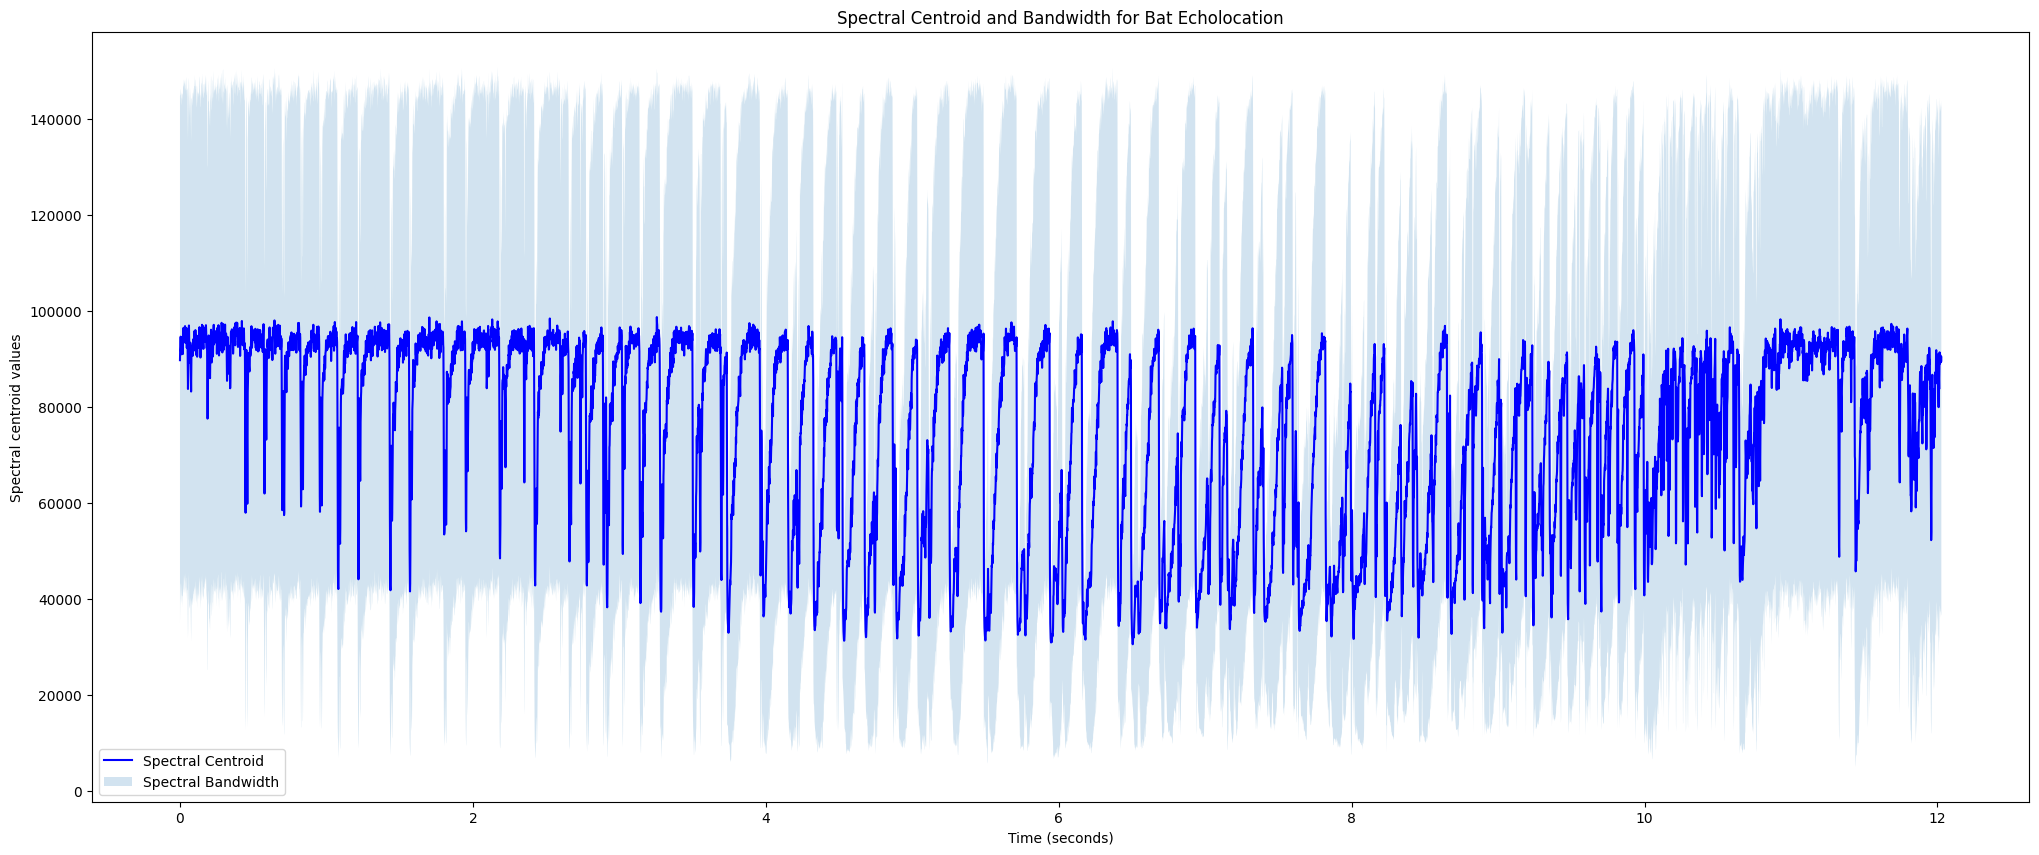

In [122]:
# Plot spectral centroid and bandwidth for bat
plot_spectral_centroid(sc_bat, sban_bat, t, 'Spectral Centroid and Bandwidth for Bat Echolocation')

In [ ]:
# While spectral centroid values aren't directly translatable to Hz, you can see that bat 
# echolocation is much higher frequency, and a broader range of frequencies than human conversation

In [109]:
# Calculate spectral centroid for elephant rumbles
sc_elephant = librosa.feature.spectral_centroid(y=elephant, sr=sr_elephant, n_fft=FRAME_LENGTH_IS, hop_length=HOP_LENGTH_IS)[0]

In [110]:
# Calculate spectral bandwidth for elephant rumbles
sban_elephant = librosa.feature.spectral_bandwidth(y=elephant, sr=sr_elephant, n_fft=FRAME_LENGTH_IS, hop_length=HOP_LENGTH_IS)[0]

In [119]:
frames = range(len(sc_elephant))
t = librosa.frames_to_time(frames, sr=sr_elephant, hop_length=HOP_LENGTH_IS)

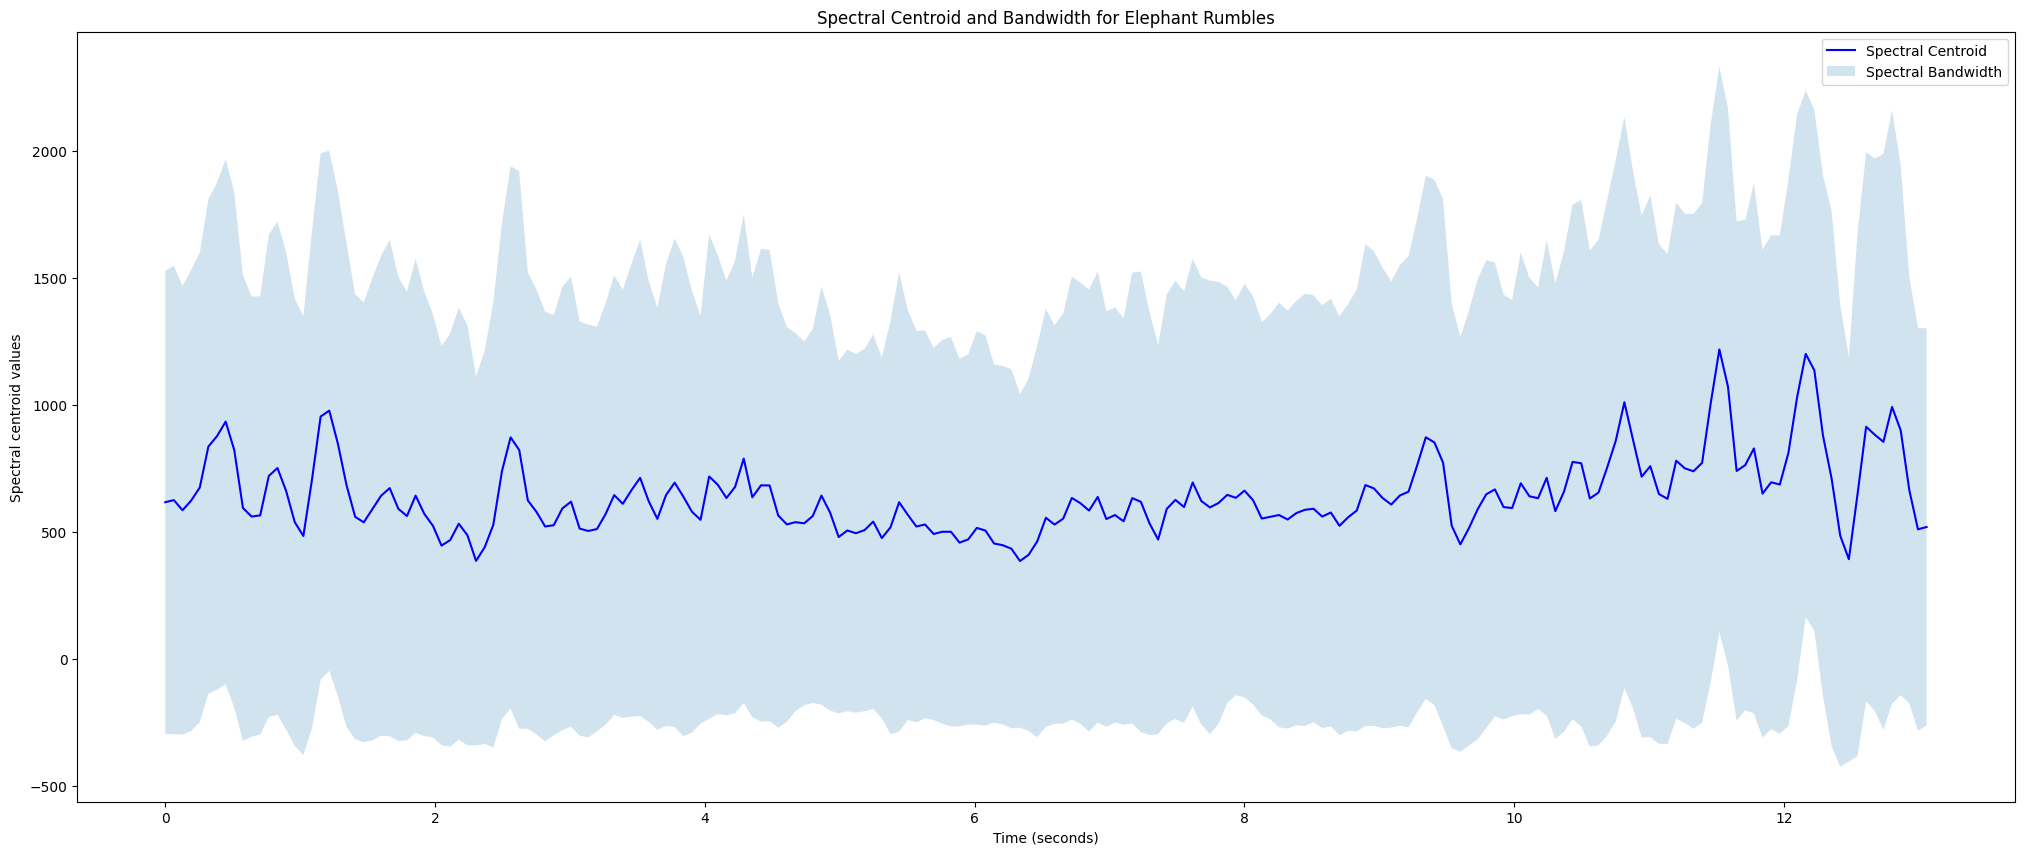

In [120]:
# Plot spectral centroid and bandwidth for elephant rumbles
plot_spectral_centroid(sc_elephant, sban_elephant, t, 'Spectral Centroid and Bandwidth for Elephant Rumbles')

In [ ]:
# While elephant rumbles are mixed in with wind and other background noise, this seems to suggest that 
# elephant + wind are low frequency, with energy across a much more narrow range of frequencies

## Save new file

In [ ]:
sf.write('bat_high_freq_only.wav', bat_filtered, sr_bat)